In [206]:
from Memoizer import memoize_to_folder

In [323]:
from scapy.all import *
from pprint import pprint
import sys
import numpy as np
import os
import dpkt

KEYLEN=8

VALUE_PKT_SIZE = 591
GET_PKT_SIZE = 64
MAX_LINE_RATE =10e9

GET_SET_RATIO = .9

In [324]:
def value_pct_of_line_rate(input_rate):
    get_rate = GET_SET_RATIO * input_rate
    set_rate = (1 - GET_SET_RATIO) * input_rate
    
    value_rate = get_rate * 8 * VALUE_PKT_SIZE
    stored_rate = set_rate * 8 * GET_PKT_SIZE
    
    return (value_rate + stored_rate) / 1e10 * 100

In [363]:
@memoize_to_folder('memo/tofino_pcaps')
def read_pcap(out_dir, dst_mac_is_ts = True, try_compare_counters = True):
    
    if try_compare_counters:
        count_file = os.path.join(out_dir, 'counters_0.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_start_pkts = int(n_pkts_str[:-1])
        count_file = os.path.join(out_dir, 'counters_1.out')
        for line in open(count_file):
            if line.startswith('5/0'):
                n_pkts_str = line.split()[-1]
                n_end_pkts = int(n_pkts_str[:-1])   
        n_expected_pkts = (n_end_pkts - n_start_pkts)
        
        print("Expecting {} packets".format(n_expected_pkts))
                
    pcf = os.path.join(out_dir, 'moongen', 'moongen.pcap')
    
    counters = {
        'set': 0,
        'miss': 0,
        'get': 0,
        'value': 0,
        'unreach': 0,
        'other': 0,
        'stored': 0
    }
    
    gets = defaultdict(list)
    vals = defaultdict(list)
    sets = defaultdict(list)
    storeds = defaultdict(list)
    

    f = open(pcf, 'rb')
    print("Reading {}".format(pcf))
    pcap=dpkt.pcap.Reader(f)
    total_size = 0
    for ts, buf in pcap:
        try:
            eth=dpkt.ethernet.Ethernet(buf)
            ip=eth.data
            if type(ip) != dpkt.ip.IP:
                counters['other'] += 1
                continue
            udp = ip.data
            total_size += udp.ulen + 44
            spkt = udp.data
        except Exception as e:
            print("Exception parsing packet {} : {}".format(buf, e))
            Ether(buf).show2()
            raise

        if dst_mac_is_ts:
            x3, x2, x1 = struct.unpack("!HHH", eth.dst)
            ts = float((x3 << 32) | (x2 << 16) | x1) * 1e-9

        if type(spkt) == dpkt.icmp.ICMP.Unreach:
            counters['unreach'] += 1
            continue

        get_start = spkt.find(b'get ')
        if get_start >= 0:
            key = spkt[:2] + spkt[get_start+4:get_start+4+KEYLEN]
            gets[key].append(ts)
            counters['get'] += 1
            continue
        val_start = spkt.find(b'VALUE ')
        if val_start >= 0:
            key = spkt[:2] + spkt[val_start+6:val_start+6+KEYLEN]
            vals[key].append((ts, ip.id))
            counters['value'] += 1
            continue
        if b'set ' in spkt:
            key = spkt[:2]
            sets[key].append(ts)
            counters['set'] += 1
        elif b'STORED' in spkt:
            key = spkt[:2]
            storeds[key].append((ts, ip.id))
            counters['stored'] += 1
            continue
        elif b'END' in spkt:
            counters['miss'] += 1
        else:
            print('Unknown packet load: {}'.format(buf))
            
    print("Finished reading pcap: ")
    pprint(counters)
    
    if ( counters['get'] != 45000 or counters['value'] != 45000
         or counters['set'] != 5000 or counters['stored'] != 5000 ) \
            and try_compare_counters:
        n_got_pkts = sum(counters.values())
        if n_got_pkts < n_expected_pkts - 1:
            print("******************\n"*5 + \
                  "GOT {} PKTS, EXPECTED {}\n".format(n_got_pkts, n_expected_pkts) +\
                  "******************\n"*5
                 )
    
    return gets, vals, sets, storeds, total_size

def rate_of_reqs(gets, sets):
    times = []
    for gt in gets.values():
        times += gt
    for st in sets.values():
        times += st
    return len(times) / (max(times) - min(times))

def rate_of_resps(gets, sets, bytes_transferred):
    times = []
    for gt in gets.values():
        times += gt
    for st in sets.values():
        times += st 
    return float(bytes_transferred) / max(times) - min(times)

In [364]:
import itertools    

def calculate_tds(reqs, resps, hits_only = False, misses_only = False):
    print("Getting TDs")
    
    req_keys = set(reqs.keys())
    resp_keys = set(resps.keys())
    
    missing_resps = 0
    for k in req_keys - resp_keys:
        missing_resps += len(reqs[k])
    
    missing_reqs = 0
    for k in resp_keys - req_keys:
        missing_reqs += len(resps[k])
    
    mismatched_length_reqs = 0
    mismatched_length_resps = 0
    tds = []
    
    for k in req_keys & resp_keys:
        
        resp = resps[k]
        mask = (np.ones(len(resp)) == 1)
        
        if misses_only:
            mask &= np.array([v[1] != 1 for v in resp])
        if hits_only:
            mask &= np.array([v[1] == 1 for v in resp])
            
        resp_times = np.array([v[0] for v in resp])
        req_times = np.array(reqs[k])
        
        lendiff = len(resp_times) - len(req_times)
        if lendiff != 0:
            mismatched_length_resps += len(resp_times)
            mismatched_length_reqs += len(req_times)
            continue
            
        new_tds = resp_times[mask] - req_times[mask]
        tds.extend([gt, td] for gt, td in zip(req_times[mask], new_tds))
        
    print("Missing {} requests".format(missing_reqs))
    print("Discarded {} requests".format(mismatched_length_reqs))
    print("Missing {} responses".format(missing_resps))
    print("Discarded {} responses".format(mismatched_length_resps))
    print("\n*** Got {} Latencies ***\n".format(len(tds)))
    
    return np.array(tds)

def experiment_success_rate(directory):
    gets, vals = read_pcap(directory)
    return get_success_percent(gets, vals), rate_of_gets(gets)

@memoize_to_folder("memo/experiment_tds")
def experiment_tds(directory, hits_only = False, misses_only = False, __recalculate=False):
    gets, vals, sets, storeds, total_length = read_pcap(directory, __recalculate=__recalculate)
    get_tds = calculate_tds(gets, vals, hits_only, misses_only)
    set_tds = calculate_tds(sets, storeds, hits_only, misses_only)
    return get_tds, set_tds, rate_of_reqs(gets, sets), rate_of_resps(gets, sets, total_length)

In [365]:
import glob
import time
import re
from multiprocessing import Pool as ThreadPool 

def experiment_tds_wrapper(arg):
    start = time.time()
    try:
        print("Running {}".format(arg))
        rtn = experiment_tds(arg)
        end = time.time()
        if rtn is None:
            rtn = experiment_tds(arg, __recalculate=True)
        print("Completed {} in {}s".format(arg, end - start))
        return rtn, arg
    except Exception as e:
        print("Did not complete {}!!!! {}".format(arg, e))
        return None
        
def dictize(d):
    d = copy.deepcopy(d)
    for k in d.keys():
        if isinstance(d[k], defaultdict):
            d[k] = dictize(d[k])
    return dict(d)

def load_all_experiments(toptopdir='inputs', depth=1, poolsize=5):
    d = toptopdir
    rec_dd = lambda : defaultdict(rec_dd)
    experiments = defaultdict(rec_dd)
    
    directories = glob.glob(os.path.join(toptopdir, '*'))
    for i in range(depth):
        new_directories = []
        for subdir in directories:
            new_directories.extend(glob.glob(os.path.join(subdir, '*')))
        directories = new_directories
        
    pool = ThreadPool(poolsize)
    results = pool.map(experiment_tds_wrapper, directories)
    pool.close()
    pool.join()
    results = [ x for x in results if x is not None]
        
    for (tds, rate, ngets), directory in results:
        split_dir = directory.split('/')
        keys = []
        for part in split_dir:
            if part not in toptopdir:
                for key in keys:
                    part = part.replace(key, '')
                    part = part.strip('_')
                keys.append(part)
        
        experiment = experiments
        for key in keys[:-1]:
            experiment = experiment[key]
        experiment[keys[-1]] = rate, tds, ngets
    
    return dictize(experiments)

In [366]:
def exp_files(topdir, exp_name, rates):
    return [
        os.path.join(topdir, exp_name, '{}_{:.2f}'.format(exp_name, rate))
        for rate in rates
    ]

def sub_exp_files(orig, orig_rates, topdir, exp_name, rates):
    sub_files = exp_files(topdir, exp_name, rates)

    for sf, sr in zip(sub_files, rates):
        orig[list(orig_rates).index(sr)] = sf
        
    return orig

In [564]:
experiment_tds.delete_memoizations('../output_mixed_2/collisions_zipf_1/collisions_zipf_1_22.00')
read_pcap.delete_memoizations('../output_mixed_2/collisions_zipf_1/collisions_zipf_1_22.00')

Removing file: memo/experiment_tds/experiment_tds__directory-output_mixed_2collisions_zipf_1collisions_zipf_1_2200__hits_only-True.pickle
Removing file: memo/experiment_tds/experiment_tds__directory-output_mixed_2collisions_zipf_1collisions_zipf_1_2200.pickle
Removing file: memo/experiment_tds/experiment_tds__directory-output_mixed_2collisions_zipf_1collisions_zipf_1_2200__misses_only-True.pickle
Removing file: memo/tofino_pcaps/read_pcap__out_dir-output_mixed_2collisions_zipf_1collisions_zipf_1_2200.pickle


In [590]:
topdir = '../data'
exp_name = 'collisions_zipf_1'
rates = [1] + list(np.arange(2, 31, 2))

collisions_files = exp_files(topdir, exp_name, rates)
# sub_exp_files(booster_only_files, rates, topdir, 'booster_only_counters_rerun_2', [5.00])

collisions = [experiment_tds(f) for f in collisions_files]
collision_hits = [experiment_tds(f, hits_only=True) for f in collisions_files]
collision_misses = [experiment_tds(f, misses_only=True) for f in collisions_files]

Expecting 100000 packets
Reading ../data/collisions_zipf_1/collisions_zipf_1_1.00/moongen/moongen.pcap
Finished reading pcap: 
{'get': 45000,
 'miss': 0,
 'other': 0,
 'set': 5000,
 'stored': 5000,
 'unreach': 0,
 'value': 45000}
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 45000 Latencies ***

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 5000 Latencies ***

Expecting 100000 packets
Reading ../data/collisions_zipf_1/collisions_zipf_1_2.00/moongen/moongen.pcap
Finished reading pcap: 
{'get': 45000,
 'miss': 0,
 'other': 0,
 'set': 5000,
 'stored': 5000,
 'unreach': 0,
 'value': 45000}
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 45000 Latencies ***

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 5000 Latencies ***

Expecting 100000 packets
Reading ../data/colli

Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 0 Latencies ***

Loading from memo/tofino_pcaps/read_pcap__out_dir-datacollisions_zipf_1collisions_zipf_1_400.pickle
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 26720 Latencies ***

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 0 Latencies ***

Loading from memo/tofino_pcaps/read_pcap__out_dir-datacollisions_zipf_1collisions_zipf_1_600.pickle
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 26449 Latencies ***

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 0 responses
Discarded 0 responses

*** Got 0 Latencies ***

Loading from memo/tofino_pcaps/read_pcap__out_dir-datacollisions_zipf_1collisions_zipf_1_800.pickle
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 4052 responses
Discarded 0 responses

*** Go

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 13464 responses
Discarded 0 responses

*** Got 8826 Latencies ***

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 2990 responses
Discarded 0 responses

*** Got 2010 Latencies ***

Loading from memo/tofino_pcaps/read_pcap__out_dir-datacollisions_zipf_1collisions_zipf_1_2000.pickle
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 14875 responses
Discarded 0 responses

*** Got 7188 Latencies ***

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 3361 responses
Discarded 0 responses

*** Got 1639 Latencies ***

Loading from memo/tofino_pcaps/read_pcap__out_dir-datacollisions_zipf_1collisions_zipf_1_2200.pickle
Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 15651 responses
Discarded 0 responses

*** Got 7159 Latencies ***

Getting TDs
Missing 0 requests
Discarded 0 requests
Missing 3507 responses
Discarded 0 responses

*** Got 1493 Latencies ***

Loading from memo/tofino_pcaps/read_pca

In [562]:
topdir = '../data'
exp_name = 'no_booster_zipf_1'
rates = [1] + list(np.arange(2, 31, 2))

no_booster_files = exp_files(topdir, exp_name, rates)
# sub_exp_files(booster_only_files, rates, topdir, 'booster_only_counters_rerun_2', [5.00])

no_booster = [experiment_tds(f) for f in no_booster_files]
no_booster_hits = [experiment_tds(f, hits_only=True) for f in no_booster_files]
no_booster_misses = [experiment_tds(f, misses_only=True) for f in no_booster_files]

Loading from memo/experiment_tds/experiment_tds__directory-output_mixed_2no_booster_zipf_1no_booster_zipf_1_100.pickle
:: Cached stdout:
 :: Expecting 100000 packets :: 
 :: Reading ../output_mixed_2/no_booster_zipf_1/no_booster_zipf_1_1.00/moongen/moongen.pcap :: 
 :: Finished reading pcap:  :: 
 :: { :: 'get' :: :  :: 45000 :: ,
  :: 'miss' :: :  :: 0 :: ,
  :: 'other' :: :  :: 0 :: ,
  :: 'set' :: :  :: 5000 :: ,
  :: 'stored' :: :  :: 5000 :: ,
  :: 'unreach' :: :  :: 0 :: ,
  :: 'value' :: :  :: 45000 :: } :: 
 :: Getting TDs :: 
 :: Missing 0 requests :: 
 :: Discarded 0 requests :: 
 :: Missing 0 responses :: 
 :: Discarded 0 responses :: 
 :: 
*** Got 45000 Latencies ***
 :: 
 :: Getting TDs :: 
 :: Missing 0 requests :: 
 :: Discarded 0 requests :: 
 :: Missing 0 responses :: 
 :: Discarded 0 responses :: 
 :: 
*** Got 5000 Latencies ***
 :: 

Loading from memo/experiment_tds/experiment_tds__directory-output_mixed_2no_booster_zipf_1no_booster_zipf_1_200.pickle
:: Cached stdout

In [398]:
no_booster

[(array([[3.36622104e+01, 3.85930000e-05],
         [3.62229714e+01, 3.88510000e-05],
         [3.81642546e+01, 4.95310000e-05],
         ...,
         [3.44675190e+01, 4.71380000e-05],
         [3.51309044e+01, 4.38600000e-05],
         [3.45488757e+01, 3.89760000e-05]]),
  array([[3.69742825e+01, 4.33600000e-05],
         [3.51638798e+01, 4.45900000e-05],
         [3.89522158e+01, 5.03840000e-05],
         ...,
         [3.43457915e+01, 5.27390000e-05],
         [3.56377039e+01, 4.69270000e-05],
         [3.64547834e+01, 5.99140000e-05]]),
  8816.986965228689,
  864195.149282209),
 (array([[3.51988509e+01, 2.51550000e-05],
         [3.37907463e+01, 2.56500000e-05],
         [3.42767829e+01, 4.93840000e-05],
         ...,
         [3.48183222e+01, 2.39050000e-05],
         [3.42921587e+01, 2.48370000e-05],
         [3.48263983e+01, 2.40800000e-05]]),
  array([[3.48849701e+01, 2.65190000e-05],
         [3.55477011e+01, 4.43870000e-05],
         [3.44066479e+01, 2.67640000e-05],
       

<IPython.core.display.Javascript object>


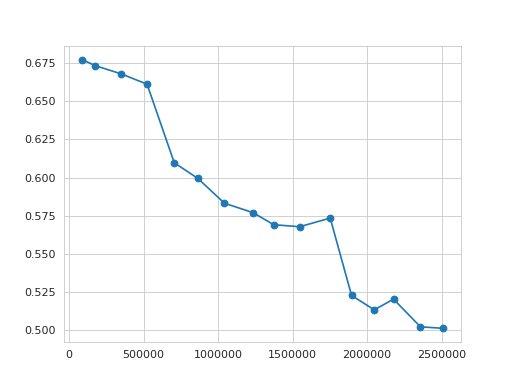

In [553]:
def plot_hit_rate(hits, misses):
    x = []
    y = []
    for h, m in zip(hits, misses):
        x.append(h[2])
        y.append(len(h[0]) / 40000.0)
        
    plt.plot(x, y, 'o-')
    
plt.figure()
plot_hit_rate(collision_hits, collision_misses)

In [45]:
def filter_tds(tds, percentile):
    return tds[tds[:,1] < np.percentile(tds[:,1], percentile)]
    

In [195]:
%matplotlib notebook
import matplotlib.pyplot as plt
def plot_timeseries(tds, label=0, gets=None, percentile=99, start_time=None):
    times, diffs = filter_tds(tds, percentile).T
#     times, diffs = zip(*sorted(zip(times, diffs), key=lambda x:x[0]))
#     times = np.array(times[-n_times:])
#     diffs = np.array(diffs[-n_times:])
    if start_time is None:
        start_time = min(times)
    scaled_times = (times - start_time)# (times - min(times)) / (max(times) - min(times))
#     scaled_times = times
    
    plt.plot(scaled_times, diffs * 1000000, '.', markersize=1, alpha=1, label=label)
    return start_time
    
def plot_histogram(tds, label):
    times, diffs = filter_tds(tds, 100).T
    diffs *= 1000000
    plt.hist(diffs, alpha=.7, bins=np.arange(100.0)/2 - .25, label=["{}k ({} drops)".format(label / 1000, 45000 - len(tds))])

<IPython.core.display.Javascript object>


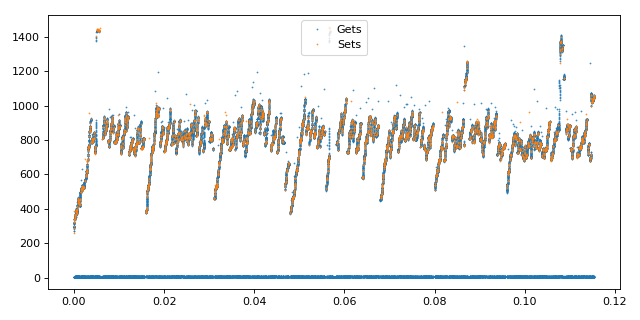

In [255]:
plt.figure(figsize=(8,4))
# plt.subplot(121)
# s = plot_timeseries(with_cache[1], label='with')
# s2 = plot_timeseries(without_cache[1], label='Without')
# plt.title("Sets")
# plt.subplot(122)

plot_timeseries(collisions[7][0], label='Gets')
plot_timeseries(collisions[7][1], label='Sets')

# plot_timeseries(with_cache_misses[0], label='with misses')

# plot_timeseries(without_cache[0], label='Without')
plt.legend()
plt.tight_layout()

In [667]:
def make_gray(infile, outfile):
    os.system('rm -f {}; \
              gs \
    -sOutputFile="{}" \
    -sDEVICE=pdfwrite \
    -sColorConversionStrategy=Mono \
    -sColorConversionStrategyForImages=/Mono \
    -dProcessColorModel=/DeviceGray \
    -dCompatibilityLevel=1.3 \
    -dNOPAUSE -dBATCH \
    "{}"'.format(outfile, outfile, infile))
    
def plot_success(experiments, full_exp, color=None, label=None, textfile=None, **kwargs):
    values = sorted(experiments, key=lambda x: x[1])
    keys = []
    y = []
    for val, exp in zip(values, full_exp):
        #keys.append(apparent_rate(exp) / 1000)
        keys.append(val[2] / 1000)
        y.append(val[0])
        
    print(keys, y)
    plt.plot(keys, y, '.-', color=color, label=label, **kwargs)
    
    if textfile:
        with open(textfile,'w') as f:
            f.write("rate\tsuccess\n")
            for key, v in zip(keys, y):
                f.write("{:d}\t{:.2f}\n".format(int(key),v))

<IPython.core.display.Javascript object>


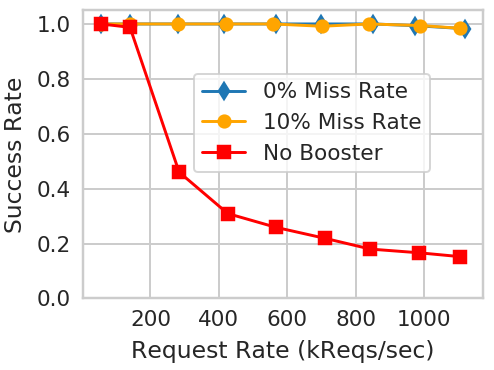

[56.67096149356208, 140.19782705775702, 279.3811164310018, 414.129541864139, 565.7061778082295, 698.284880913931, 851.4105921279662, 971.9325703915008, 1119.7155498684187] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9938750100409671, 0.9828148088172783]
[55.72260497183914, 140.15856753221843, 280.7849626919127, 421.052293434309, 558.7845651281887, 701.0767785566956, 838.8171780169845, 989.0186346243981, 1104.556724764436] [1.0, 1.0, 1.0, 1.0, 1.0, 0.99164, 0.999979998399872, 0.9943179536602016, 0.9842033939442972]
[56.6608100692768, 140.45463282515703, 284.0214632613648, 426.1378091154776, 567.6262653602555, 709.2712656040205, 843.0863487800858, 984.3288555952951, 1104.6828415208436] [1.0, 0.9876, 0.46008, 0.3092, 0.2588, 0.21928, 0.17976, 0.1664, 0.15232]


In [715]:
%matplotlib notebook
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')

plt.figure(figsize=(4*.7,3*.7))
plot_success(upset_booster_only_success, upset_booster_only, label='0% Miss Rate', marker='d', textfile='no_miss_success.txt')
plot_success(booster_misses_90_10_success, booster_misses_90_10, color='orange', label='10% Miss Rate', marker='o', textfile='90_10_success.txt')
plot_success(upset_mcd_only_success, upset_mcd_only, color='red', label='No Booster', marker='s', textfile='no_booster_success.txt')
plt.ylim([0,1.05])
plt.ylabel("Success Rate")
plt.xlabel("Request Rate (kReqs/sec)")
plt.legend(bbox_to_anchor=(.25,.4, .1, .1))

plt.gca().tick_params('x',pad=0)
plt.gca().tick_params('y',pad=0)

plt.tight_layout(pad=.1)
plt.savefig("mcd_success.pdf")
make_gray('mcd_success.pdf', 'mcd_success_gray.pdf')



In [84]:
np.percentile(booster_only[0][0][:,1],.5, )

5.981000001042958e-06

In [101]:
booster_only[-2][1]

1581382.457578274

In [442]:
def plot_success(experiments, marker, sets_only=False, color=None, label=None, textfile=None, do_top=False):
    rates = []
    y = []
    for experiment in experiments:
        rates.append(experiment[2] / 1000)
        if sets_only:
            y.append(len(experiment[1]) / 5000 * 100)
        else:
            y.append(len(experiment[0]) / 45000 * 100)
    
    plt.plot(rates, y, marker, color=color, label=label)
    plt.xlabel("Request Rate (kReq/s)")
    plt.ylabel("% Success")
    
    if do_top:
        ax = plt.gca()
        axt = ax.twiny()
        axt.grid(False)
        xlims = ax.get_xlim()
        toplims = value_pct_of_line_rate([['', x*1000] for x in xlims])
        axt.set_xlim(toplims)

        xticks = [0, 500, 1000, 1500, 2000]
        ax.set_xticks(xticks)
        topticks = value_pct_of_line_rate([['', x*1000] for x in xticks])

        print( xlims)
        axt.set_xticks(topticks)
        axt.set_xticklabels(["%d%%" % x for x in topticks])

        axt.set_xlabel("Response Rate (% of Line Rate)")
        plt.sca(ax)


In [573]:
import seaborn as sns
LOW_PCT = 5
HIGH_PCT = 95

def plot_latency(experiments, sets_only=False, color=None, label=None, marker='.-', do_top=False):
    rates = []
    mid, sub, sup = [], [], []
    for i, experiment in enumerate(experiments):
        if len(experiment[0]) == 0:
            print("No latencies for experiment {}".format(i))
            continue
        rates.append(experiment[2] / 1000)
        if sets_only:
            lats = experiment[1][:,1] * 1e6
        else:
            lats = experiment[0][:,1] * 1e6
        mid.append(np.median(lats))
        sub.append(np.percentile(lats, LOW_PCT))
        sup.append(np.percentile(lats, HIGH_PCT))
       
    ax = plt.gca()
        
    ax.fill_between(rates, sub, sup, alpha=.2, color=color)
    ax.plot(rates, mid, marker, label=label, color=color, zorder=10, )
    ax.set_xlabel("Request Rate (kReq/s)")
    ax.set_ylabel("Latency ($\mu s$)")
    
    if do_top:

        axt = ax.twiny()
        axt.grid(False)
        xlims = ax.get_xlim()
        toplims = [value_pct_of_line_rate(x*1000) for x in xlims]
        axt.set_xlim(toplims)

        xticks = [0, 500, 1000, 1500, 2000]
        ax.set_xticks(xticks)
        topticks = [value_pct_of_line_rate(x*1000) for x in xticks]

        axt.set_xticks(topticks)
        axt.set_xticklabels(["%d%%" % x for x in topticks])

        axt.set_xlabel("Response Rate (% of Line Rate)")
        plt.sca(ax)

    


In [588]:
def make_comparison_plots(collisions, no_booster, sets_only):
    sns.set_style('whitegrid')
    plt.figure(figsize=(8,3))
    plt.subplot(121)
    plot_latency(no_booster, sets_only=sets_only, marker='d-', color='red')
    plot_latency(collisions, sets_only=sets_only, color='blue')
    if sets_only:
        plt.title("SET Latency")
    else:
        plt.title("GET Latency")
            
#     plt.yscale('log')
#     plt.xscale('log')
    plt.subplot(122)
    plot_success(no_booster, 'd-', sets_only=sets_only, color='red')
    plot_success(collisions, '.-', sets_only=sets_only, color='blue')
    if sets_only:
        plt.title("SET Success")
    else:
        plt.title("GET Success")
    plt.ylim([0, 110])
    plt.tight_layout()

<IPython.core.display.Javascript object>


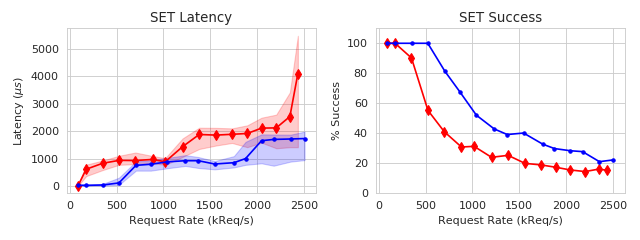

<IPython.core.display.Javascript object>


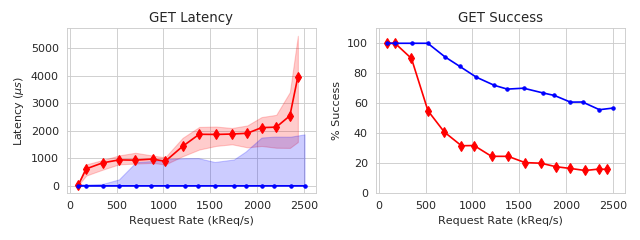

In [589]:
make_comparison_plots(collisions, no_booster, True)
make_comparison_plots(collisions, no_booster, False)


<IPython.core.display.Javascript object>


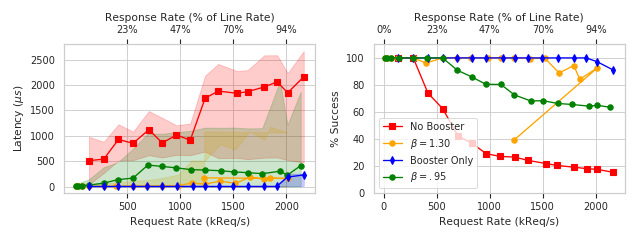

(-93.55206881063455, 2271.600645066145)


In [992]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,3))
plt.subplot(122)
plot_success(no_booster, marker='s-', color='red', label='No Booster')
# plot_success(collision_10, marker='o-', color='orange', label='10% Collision')
# plot_success(collision_50, marker='o-', color='green', label='50% Collision')
# plot_success(uniform_random, marker='o-', color='purple', label='Uniform Rand.')
plot_success(zipf_130, marker='o-', color='orange', label=r'$\beta = 1.30$')
plot_success(booster_only, marker='d-', color='blue', label='Booster Only', do_top=True)
plot_success(zipf_95, marker='o-', color='green', label=r'$\beta = .95$')
plt.ylim([0,110])
plt.legend()

plt.subplot(121)
plot_latency(no_booster, marker='s-', color='red')
# plot_latency(collision_10, marker='o-', color='orang')
# plot_latency(collision_50, marker='o-', color='green')
# plot_latency(uniform_random, marker='o-', color='purple')
plot_latency(zipf_130, marker='o-', color='orange', label=r'$\beta = 1.30$')
plot_latency(zipf_95, marker='o-', color='green', label=r'$\beta = .95$')
plot_latency(booster_only, marker='d-', color='blue', do_top=True)

plt.tight_layout()

<IPython.core.display.Javascript object>


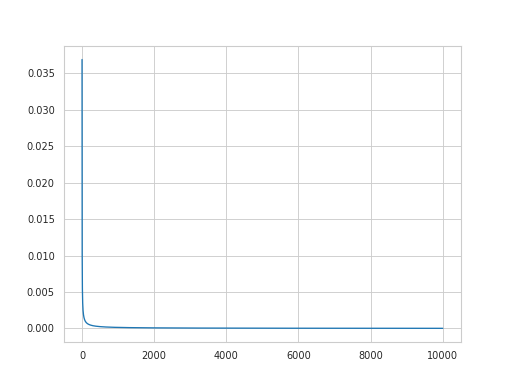

In [724]:
denoms = {}
def denom(n, s):
    if (n, s) in denoms:
        return denoms[(n, s)]
    if n == 1:
        return 1
    
    denoms[(n, s)] = sum([1/i**s for i in range(1, n+1)])
    return denoms[(n, s)]

def freq(k, s, n):
    return (1/k**s)/denom(n, s)

freqs = [freq(i, .8, 10000) for i in range(1, 10001)]

plt.figure()
plt.plot(freqs)

In [447]:

    
cols = ["#9c2b2a",
"#3d8500",
"#0086b3"]
def plot_experiments(experiments, successes, threshold=None, color=None, label=None, marker=None, textfile=None, **kwargs):
    try:
        values = experiments.values
    except:
        values = experiments
    values = sorted(values, key = lambda x: x[1])
    keys = []
    sub, sup = [], []
    no = []
    for vals, succ in zip(values, successes):
        if len(vals[0]) == 0:
            continue
        keys.append(succ[2] / 1000)
        val = vals[0]
#       keys.append(apparent_rate(vals) / 1000)
#         keys.append(apparent_rate(vals) / 1000)
    
        if threshold is not None:
            low = val[val[:,1] < threshold,1]
            high = val[val[:,1] > threshold,1]
            print('HIT RATE: ', float(len(low)) / float(len(high) + len(low)))
            sub.append([np.percentile(low, x) * 1000000 for x in (10, 50, 99)])
            sup.append([np.percentile(high, x) * 1000000 for x in (10, 50, 99)])
            print(float(len(high)) / len(low))
            #_, lowdiffs = filter_tds(low, 90).T
            #_, hidiffs = filter_tds(high, 90).T
            #sub.append(lowdiffs.mean() * 1000)
            #sup.append(hidiffs.mean() * 1000)
        else:
            no.append([np.percentile(val[:,1], x) * 1000000 for x in (10, 50, 90)])
    if no:
        print(keys)
        low, med, high = zip(*no)
        plt.fill_between(keys, low, high, alpha=.3, color=color or cols[2], **kwargs)
        
        plt.plot(keys, med, marker, label=label, color=color or cols[2], zorder=10)
        #print('no', no)
        if textfile:
            with open(textfile,'w') as f:
                f.write("rate\t10th\t50th\t90th\n")
                for key, l, m, h in zip(keys, low, med, high):
                    f.write("{:d}\t{:.2f}\t{:.2f}\t{:.2f}\n".format(int(key), l, m, h))
        
    if sub:
        #print(sub)
        low, med, high = zip(*sub)
        plt.fill_between(keys, low, high, label='Booster Hits', color=cols[0], alpha=.5)
        plt.plot(keys, med, marker, color=cols[0])
    if sup:
        low, med, high = zip(*sup)
        plt.fill_between(keys, low, high, label='Booster Misses', alpha=.2, color=cols[1])
        plt.plot(keys, med, marker, color=color or cols[1])
        #print(sup)
    keys

<IPython.core.display.Javascript object>


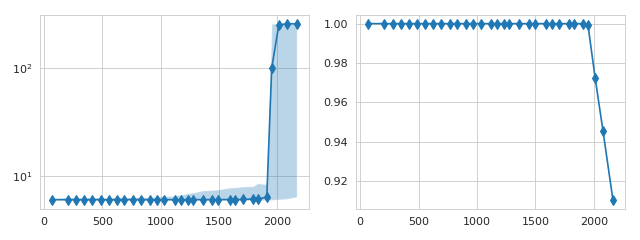

In [691]:
max(np.percentile(x[0][:,1], 99) for x in upset_booster_only)

0.0004889965057373047

<IPython.core.display.Javascript object>


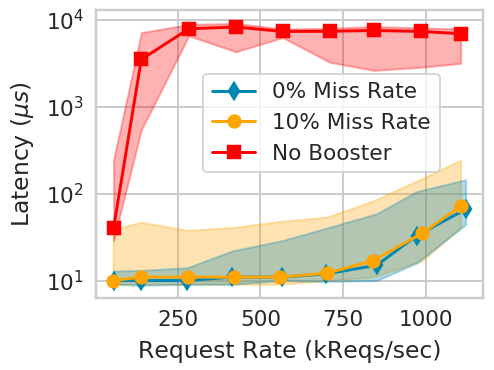

[56.67096149356208, 140.19782705775702, 279.3811164310018, 414.129541864139, 565.7061778082295, 698.284880913931, 851.4105921279662, 971.9325703915008, 1119.7155498684187]
[55.72260497183914, 140.15856753221843, 280.7849626919127, 421.052293434309, 558.7845651281887, 701.0767785566956, 838.8171780169845, 989.0186346243981, 1104.556724764436]
[56.6608100692768, 140.45463282515703, 284.0214632613648, 426.1378091154776, 567.6262653602555, 709.2712656040205, 843.0863487800858, 984.3288555952951, 1104.6828415208436]


In [714]:
plt.figure(figsize=(4*.7,3*.7))

plot_experiments(upset_booster_only, upset_booster_only_success, label='0% Miss Rate', marker='d-', textfile="no_miss_lat.txt", zorder=10)
plot_experiments(booster_misses_90_10, booster_misses_90_10_success, color='orange', label='10% Miss Rate', marker='o-', textfile="90_10_lat.txt")
plot_experiments(upset_mcd_only, upset_mcd_only_success,  color='red', label='No Booster', marker='s-', textfile="no_booster_lat.txt")
# plot_experiments(booster_misses_50_50, booster_misses_50_50_success, color='green', label='50% Collision')

plt.ylabel(r"Latency ($\mu s$)")
plt.xlabel("Request Rate (kReqs/sec)")
plt.yscale("log")
plt.legend(bbox_to_anchor=(.25, .4, .1, .1))
plt.gca().tick_params('x',pad=0)
plt.gca().tick_params('y',pad=0)

plt.tight_layout(pad=.1)
plt.savefig("mcd_latency.pdf", frameon=True)

make_gray('mcd_latency.pdf', 'mcd_latency_gray.pdf')

#plot_experiments(pre_tds, None, color='green')

In [517]:
np.median(hm_tds[0][:,1])*1e6, np.median(hm_tds[1][:,1])*1e6, np.median(upset_mcd_only[0][0][:,1]*1e6)

(10.013580322265625, 61.98883056640625, 40.0543212890625)

In [571]:
collision_50_hits[0][:,1]

array([6.02700000e-06, 6.02100000e-06, 6.08300000e-06, ...,
       6.07299999e-06, 7.24400000e-06, 5.99600000e-06])

<IPython.core.display.Javascript object>


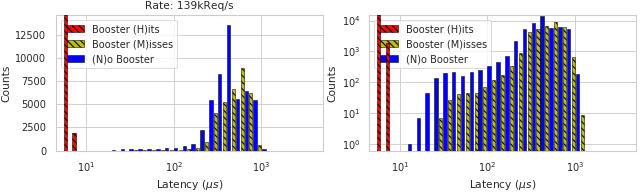

<IPython.core.display.Javascript object>


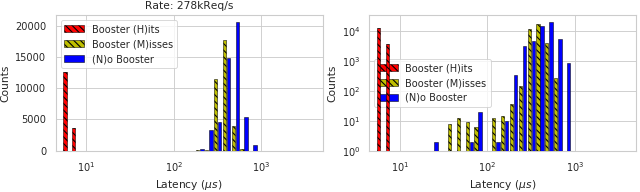

<IPython.core.display.Javascript object>


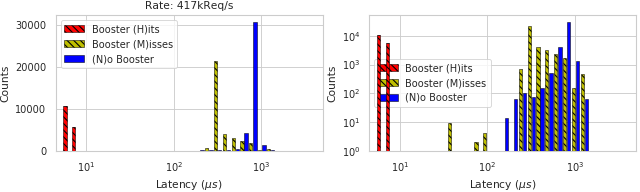

<IPython.core.display.Javascript object>


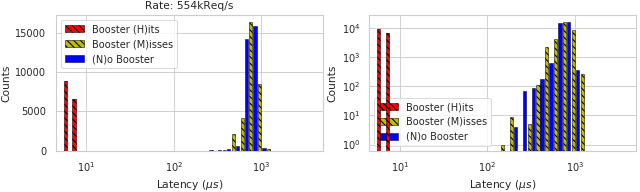

<IPython.core.display.Javascript object>


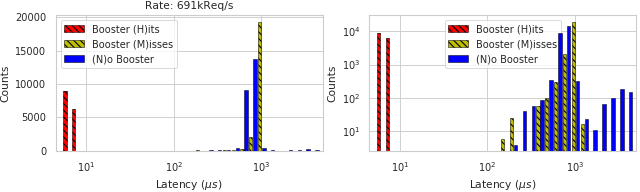

In [708]:
from matplotlib.font_manager import FontProperties
sns.set_context('paper')
def make_hist(experiments, textfile=None, logy=False, **kwargs):
    data = []
    for exp in experiments:
        data.append(exp[0][:,1] * 1e6)
    
    counts, bins, bars = plt.hist(data, np.logspace(0, 10, 100), histtype='bar', zorder=10, **kwargs)
    if logy:
        plt.yscale('log')
#     plt.ylim([1,9e5])
#     plt.ylim([0,1.4e4])
    plt.xscale('log')
    

    plt.xlim([4.5, 5000])
    
#     if textfile:
#         with open(textfile, 'w') as f:
#             f.write("bin_start\t10%miss\tno_boost\n")
#             for b, c1, c2 in zip(bins, counts[0], counts[1]):
#                 f.write("{}\t{}\t{}\n".format(int(b), c1, c2))
#                 print(b,c1,c2)

    
def make_hists(hits, misses, nobooster, logy=False):    
    

    make_hist([hits, misses], logy=logy, textfile='mcd_hist.txt', color=['r', 'y'], edgecolor='k', linewidth=.45, rwidth=.35, stacked=True, hatch=r'\\\\')
    make_hist([nobooster], color=['b'], logy=logy, edgecolor='black', rwidth=.35, align='left', linewidth=.45)

    f = FontProperties()
    f.set_weight('bold')

    f.set_size(10)
    # plt.text(10.01,60000, 'H', color='r', horizontalalignment='center', fontproperties=f)
    # plt.text(62.0,20000, 'M', color='orange', horizontalalignment='center', fontproperties=f)
    # plt.text(40.1,60000,'N', color='b', horizontalalignment='center', fontproperties=f)

    plt.legend(['Booster (H)its', 'Booster (M)isses', '(N)o Booster'])


    # plt.axvline(10.01, 0,.8, color='r', linestyle=':', zorder=1)    
    # plt.axvline(40.1, 0,.8, color='b', linestyle=':', zorder=-1)
    # plt.axvline(62.0, 0, 0.75, color='orange', linestyle=':', zorder=-1)    
    # plt.gca().tick_params('x',pad=0)
    # plt.gca().tick_params('y',pad=0)

    plt.xlabel(r"Latency ($\mu s$)")
    plt.ylabel("Counts")
# make_gray('mcd_hist.pdf', 'mcd_hist_gray.pdf')

hit_exp, miss_exp, nb_exp = zipf_random_hits, zipf_random_misses, no_booster[1::2]

for exp_i in range(5):
    plt.figure(figsize=(10*.8, 3*.8))
    plt.subplot(121)
    make_hists(hit_exp[exp_i], miss_exp[exp_i], nb_exp[exp_i])  
    plt.title('Rate: %dkReq/s' % (nb_exp[exp_i][1] / 1000))
    plt.subplot(122)
    make_hists(hit_exp[exp_i], miss_exp[exp_i], nb_exp[exp_i], True)  

    plt.tight_layout(pad=0)
    #     plt.savefig("mcd_hist.pdf", frameon=True)
